In [1]:
import matplotlib.pyplot as plt
import seaborn
import random
import math
import pickle
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
mimic = pd.read_csv("data/Processed/MIMIC.csv").drop(columns=['Unnamed: 0'], axis=1)
mimic.head()

,PATIENT_KEY,AGE,GENDER,OBESITY,Procedures_ICD9_Features,Medication_NDC_Features,Lab_Chart_Features,y_Expired,y_Non.Adherence,y_Developmental.Delay.Retardation,y_Advanced.Heart.Disease,y_Advanced.Lung.Disease,y_Schizophrenia.and.other.Psychiatric.Disorders,y_Alcohol.Abuse,y_Other.Substance.Abuse,y_Chronic.Pain.Fibromyalgia,y_Chronic.Neurological.Dystrophies,y_Advanced.Cancer,y_Depression,y_Dementia
0,9973_100020_282580,58,0,0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1 1 1 ... 0 0 0],1,0,0,0,0,0,0,0,1,1,0,0,0
1,3365_100103_200434,72,1,0,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",[0 0 0 ... 0 0 0],0,0,0,0,0,0,0,0,0,0,0,0,0
2,27290_100137_212691,82,0,0,"[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0 0 0 ... 0 0 0],1,0,0,0,0,0,0,0,0,0,0,0,0
3,9882_100177_251800,55,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 ... 0 0 0],0,0,0,0,0,0,0,0,0,0,0,0,0
4,5525_100473_257484,65,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...",[0 0 0 ... 0 0 0],1,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
subj_ids = []
for i in range(len(mimic)):
    patient = mimic["PATIENT_KEY"][i]
    subjid = int(patient.split("_")[0])
    subj_ids.append(subjid)
    
subj_ids = np.array(list(set(subj_ids)))
print(len(subj_ids))

1008


In [4]:
subj_train, subj_temp = train_test_split(subj_ids, test_size=0.2, random_state=42)
subj_val, subj_test = train_test_split(subj_temp, test_size=0.5, random_state=42)
print(len(subj_train), len(subj_val), len(subj_test))

806 101 101


## Trying for 1 task

In [5]:
label = "y_Expired"
X = np.load("data/Processed/MIMIC_X.npy")
y = np.array(list(mimic[label]))

X_train = []
X_val = []
X_test = []
y_train = []
y_val = []
y_test = []

for i in range(len(mimic)):
    features = X[i]
    label = y[i]
    subjid = int(mimic["PATIENT_KEY"][i].split("_")[0])
    if(subjid in subj_train):
        X_train.append(np.array(features))
        y_train.append(label)
    elif(subjid in subj_val):
        X_val.append(np.array(features))
        y_val.append(label)
    else:
        X_test.append(np.array(features))
        y_test.append(label)
        
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test))

1183 1183 149 149 151 151


#### Tune these Hyperparameters to solve Class Imbalance and Regularization

In [5]:
reg_alpha = 0.1
reg_c = 0.5
reg_neighbors = 10
reg_estimators = 10
smote_sampling = 'auto'
under_sampling = 'auto'

In [7]:
models = [
    ('LR', LogisticRegression(class_weight='balanced', C=reg_c, max_iter=1000)),
    ('RF', RandomForestClassifier(class_weight='balanced', n_estimators=reg_estimators,)),
    ('GB', GradientBoostingClassifier(n_estimators=reg_estimators,)),
    ('SVM_scaler', make_pipeline(StandardScaler(), SVC(class_weight='balanced', C=reg_c))),
    ('KNN_scaler', make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=reg_neighbors))),
    ('MLP1_scaler', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', alpha=reg_alpha*5, max_iter=1000))),
    ('MLP2_scaler', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(50, 50), activation='logistic', alpha=reg_alpha*4, max_iter=1000))),
    ('MLP3_scaler', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', alpha=reg_alpha*3, max_iter=1000))),
    ('MLP4_scaler', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(200, 100, 50), activation='logistic', alpha=reg_alpha*2, max_iter=1000))),
    ('MLP5_scaler', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(300, 200, 100, 50), activation='logistic', alpha=reg_alpha, max_iter=1000)))]

#     [('LR', ImbPipeline([
#         ('sampling', SMOTE(sampling_strategy=smote_sampling)),
#         ('sampling2', RandomUnderSampler(sampling_strategy=under_sampling)),
#         ('classifier', LogisticRegression(C=reg_c, max_iter=1000))
#     ])),
#     ('RF', ImbPipeline([
#         ('sampling', SMOTE(sampling_strategy=smote_sampling)),
#         ('sampling2', RandomUnderSampler(sampling_strategy=under_sampling)),
#         ('classifier', RandomForestClassifier(n_estimators=reg_estimators))
#     ])),
#     ('GB', ImbPipeline([
#         ('sampling', SMOTE(sampling_strategy=smote_sampling)),
#         ('sampling2', RandomUnderSampler(sampling_strategy=under_sampling)),
#         ('classifier', GradientBoostingClassifier(n_estimators=reg_estimators))
#     ])),
#     ('SVM_scaler', ImbPipeline([
#         ('scaler', StandardScaler()),
#         ('sampling', SMOTE(sampling_strategy=smote_sampling)),
#         ('sampling2', RandomUnderSampler(sampling_strategy=under_sampling)),
#         ('classifier', SVC(C=reg_c))
#     ])),
#     ('KNN_scaler', ImbPipeline([
#         ('scaler', StandardScaler()),
#         ('sampling', SMOTE(sampling_strategy=smote_sampling)),
#         ('sampling2', RandomUnderSampler(sampling_strategy=under_sampling)),
#         ('classifier', KNeighborsClassifier(n_neighbors=reg_neighbors))
#     ])),
#     ('MLP1_scaler', ImbPipeline([
#         ('scaler', StandardScaler()),
#         ('sampling', SMOTE(sampling_strategy=smote_sampling)),
#         ('sampling2', RandomUnderSampler(sampling_strategy=under_sampling)),
#         ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, activation='logistic', alpha=reg_alpha*5))
#     ])),
#     ('MLP2_scaler', ImbPipeline([
#         ('scaler', StandardScaler()),
#         ('sampling', SMOTE(sampling_strategy=smote_sampling)),
#         ('sampling2', RandomUnderSampler(sampling_strategy=under_sampling)),
#         ('classifier', MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, activation='logistic', alpha=reg_alpha*4))
#     ])),
#     ('MLP3_scaler', ImbPipeline([
#         ('scaler', StandardScaler()),
#         ('sampling', SMOTE(sampling_strategy=smote_sampling)),
#         ('sampling2', RandomUnderSampler(sampling_strategy=under_sampling)),
#         ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, activation='logistic', alpha=reg_alpha*3))
#     ])),
#     ('MLP4_scaler', ImbPipeline([
#         ('scaler', StandardScaler()),
#         ('sampling', SMOTE(sampling_strategy=smote_sampling)),
#         ('sampling2', RandomUnderSampler(sampling_strategy=under_sampling)),
#         ('classifier', MLPClassifier(hidden_layer_sizes=(200, 100, 50), max_iter=1000, activation='logistic', alpha=reg_alpha*2))
#     ])),
#     ('MLP5_scaler', ImbPipeline([
#         ('scaler', StandardScaler()),
#         ('sampling', SMOTE(sampling_strategy=smote_sampling)),
#         ('sampling2', RandomUnderSampler(sampling_strategy=under_sampling)),
#         ('classifier', MLPClassifier(hidden_layer_sizes=(300, 200, 100, 50), max_iter=1000, activation='logistic', alpha=reg_alpha))
#     ]))]
    
for model_name, model in models:
    sm = SMOTE(sampling_strategy=smote_sampling)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    rus = RandomUnderSampler(sampling_strategy=under_sampling)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    print(len(y_train), np.sum(np.array(y_train)))
    print(f"Training {model_name}")
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    auc_prc_train = average_precision_score(y_train, y_train_pred)
    auc_prc_val = average_precision_score(y_val, y_val_pred)
    auc_prc_test = average_precision_score(y_test, y_test_pred)
    auc_roc_train = roc_auc_score(y_train, y_train_pred)
    auc_roc_val = roc_auc_score(y_val, y_val_pred)
    auc_roc_test = roc_auc_score(y_test, y_test_pred)
    report_val = classification_report(y_val, y_val_pred)
    print(f"Train Accuracy: {accuracy_train:.4f}")
    print(f"Validation Accuracy: {accuracy_val:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Train AUCPRC: {auc_prc_train:.4f}")
    print(f"Validation AUCPRC: {auc_prc_val:.4f}")
    print(f"Test AUCPRC: {auc_prc_test:.4f}")
    print(f"Train AUROC: {auc_roc_train:.4f}")
    print(f"Validation AUROC: {auc_roc_val:.4f}")
    print(f"Test AUROC: {auc_roc_test:.4f}")
    print()

1478 739
Training LR
Train Accuracy: 0.9594
Validation Accuracy: 0.6711
Test Accuracy: 0.6556
Train AUCPRC: 0.9460
Validation AUCPRC: 0.6795
Test AUCPRC: 0.6639
Train AUROC: 0.9594
Validation AUROC: 0.6605
Test AUROC: 0.6320

1478 739
Training RF
Train Accuracy: 0.9939
Validation Accuracy: 0.6510
Test Accuracy: 0.7086
Train AUCPRC: 0.9932
Validation AUCPRC: 0.6680
Test AUCPRC: 0.7174
Train AUROC: 0.9939
Validation AUROC: 0.6432
Test AUROC: 0.7039

1478 739
Training GB
Train Accuracy: 0.7673
Validation Accuracy: 0.6510
Test Accuracy: 0.6623
Train AUCPRC: 0.7116
Validation AUCPRC: 0.6642
Test AUCPRC: 0.6947
Train AUROC: 0.7673
Validation AUROC: 0.6386
Test AUROC: 0.6694

1478 739
Training SVM_scaler
Train Accuracy: 0.8410
Validation Accuracy: 0.7450
Test Accuracy: 0.7152
Train AUCPRC: 0.7796
Validation AUCPRC: 0.7162
Test AUCPRC: 0.7069
Train AUROC: 0.8410
Validation AUROC: 0.7167
Test AUROC: 0.6948

1478 739
Training KNN_scaler
Train Accuracy: 0.5406
Validation Accuracy: 0.4698
Test Acc

### Huge class imbalance problem

In [6]:
for column in mimic.columns:
    if(column[:2]=="y_"):
        print(column, np.sum(np.array(list(mimic[column]))), len(mimic)-np.sum(np.array(list(mimic[column]))))

y_Expired 915 568
y_Non.Adherence 141 1342
y_Developmental.Delay.Retardation 34 1449
y_Advanced.Heart.Disease 246 1237
y_Advanced.Lung.Disease 150 1333
y_Schizophrenia.and.other.Psychiatric.Disorders 275 1208
y_Alcohol.Abuse 185 1298
y_Other.Substance.Abuse 145 1338
y_Chronic.Pain.Fibromyalgia 303 1180
y_Chronic.Neurological.Dystrophies 345 1138
y_Advanced.Cancer 151 1332
y_Depression 430 1053
y_Dementia 104 1379


## All Tasks

In [11]:
def train(feature_name, npy_file, df, models, model_directory):
    
    train_dict = dict()
    
    X = np.load(npy_file)
    y = np.array(list(df[feature_name]))

    X_train = []
    X_val = []
    X_test = []
    y_train = []
    y_val = []
    y_test = []

    for i in range(len(df)):
        features = X[i]
        label = y[i]
        subjid = int(df["PATIENT_KEY"][i].split("_")[0])
        if(subjid in subj_train):
            X_train.append(np.array(features))
            y_train.append(label)
        elif(subjid in subj_val):
            X_val.append(np.array(features))
            y_val.append(label)
        else:
            X_test.append(np.array(features))
            y_test.append(label)

    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)
    
    for model_name, model in models:
        sm = SMOTE(sampling_strategy=smote_sampling)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        rus = RandomUnderSampler(sampling_strategy=under_sampling)
        X_train, y_train = rus.fit_resample(X_train, y_train)
    
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        accuracy_train = accuracy_score(y_train, y_train_pred)
        accuracy_val = accuracy_score(y_val, y_val_pred)
        accuracy_test = accuracy_score(y_test, y_test_pred)
        
        auc_prc_train = average_precision_score(y_train, y_train_pred)
        auc_prc_val = average_precision_score(y_val, y_val_pred)
        auc_prc_test = average_precision_score(y_test, y_test_pred)
        
        auc_roc_train = roc_auc_score(y_train, y_train_pred)
        auc_roc_val = roc_auc_score(y_val, y_val_pred)
        auc_roc_test = roc_auc_score(y_test, y_test_pred)
        
        report_train = classification_report(y_train, y_train_pred)
        report_val = classification_report(y_val, y_val_pred)
        report_test = classification_report(y_test, y_test_pred)
        name = model_directory+str(feature_name)+"_"+model_name+".pkl"
        with open(name, 'wb') as file:
            pickle.dump(model, file)
        train_dict[model_name] = dict()
        train_dict[model_name]['Train_Accuracy'] = accuracy_train
        train_dict[model_name]['Val_Accuracy'] = accuracy_val
        train_dict[model_name]['Test_Accuracy'] = accuracy_test
        train_dict[model_name]['Train_AUCPRC'] = auc_prc_train
        train_dict[model_name]['Val_AUCPRC'] = auc_prc_val
        train_dict[model_name]['Test_AUCPRC'] = auc_prc_test
        train_dict[model_name]['Train_AUCROC'] = auc_roc_train
        train_dict[model_name]['Val_AUCROC'] = auc_roc_val
        train_dict[model_name]['Test_AUCROC'] = auc_roc_test
        train_dict[model_name]['Train_Report'] = report_train
        train_dict[model_name]['Val_Report'] = report_val
        train_dict[model_name]['Test_Report'] = report_test
        train_dict[model_name]['Train_Y'] = list(y_train)
        train_dict[model_name]['Val_Y'] = list(y_val)
        train_dict[model_name]['Test_Y'] = list(y_test)
        train_dict[model_name]['Train_X'] = list(X_train)
        train_dict[model_name]['Val_X'] = list(X_val)
        train_dict[model_name]['Test_X'] = list(X_test)
        train_dict[model_name]['Train_Y_Pred'] = list(y_train_pred)
        train_dict[model_name]['Val_Y_Pred'] = list(y_val_pred)
        train_dict[model_name]['Test_Y_Pred'] = list(y_test_pred)
    
    return train_dict

In [12]:
master_dict = dict()

labels = ["y_Expired", "y_Non.Adherence", "y_Developmental.Delay.Retardation", "y_Advanced.Heart.Disease", 
          "y_Advanced.Lung.Disease", "y_Schizophrenia.and.other.Psychiatric.Disorders", "y_Alcohol.Abuse", 
          "y_Other.Substance.Abuse", "y_Chronic.Pain.Fibromyalgia", "y_Chronic.Neurological.Dystrophies", 
          "y_Advanced.Cancer", "y_Depression", "y_Dementia"]

npy_file = "./data/Processed/MIMIC_X.npy"
model_directory = "./Baseline/Baseline_Models/"

models = [
    ('LR', LogisticRegression(class_weight='balanced', C=reg_c, max_iter=1000)),
    ('RF', RandomForestClassifier(class_weight='balanced', n_estimators=reg_estimators,)),
    ('GB', GradientBoostingClassifier(n_estimators=reg_estimators,)),
    ('SVM_scaler', make_pipeline(StandardScaler(), SVC(class_weight='balanced', C=reg_c))),
    ('KNN_scaler', make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=reg_neighbors))),
    ('MLP1_scaler', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', alpha=reg_alpha*5, max_iter=1000))),
    ('MLP2_scaler', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(50, 50), activation='logistic', alpha=reg_alpha*4, max_iter=1000))),
    ('MLP3_scaler', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', alpha=reg_alpha*3, max_iter=1000))),
    ('MLP4_scaler', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(200, 100, 50), activation='logistic', alpha=reg_alpha*2, max_iter=1000))),
    ('MLP5_scaler', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(300, 200, 100, 50), activation='logistic', alpha=reg_alpha, max_iter=1000)))
        ]

    
for label in labels:
    print("Training for Task:", label)
    master_dict[label] = dict()
    master_dict[label] = train(label, npy_file, mimic, models, model_directory)

Training for Task: y_Expired
Training for Task: y_Non.Adherence
Training for Task: y_Developmental.Delay.Retardation
Training for Task: y_Advanced.Heart.Disease
Training for Task: y_Advanced.Lung.Disease
Training for Task: y_Schizophrenia.and.other.Psychiatric.Disorders
Training for Task: y_Alcohol.Abuse
Training for Task: y_Other.Substance.Abuse
Training for Task: y_Chronic.Pain.Fibromyalgia
Training for Task: y_Chronic.Neurological.Dystrophies
Training for Task: y_Advanced.Cancer
Training for Task: y_Depression
Training for Task: y_Dementia


In [13]:
for label in labels:
    df = pd.DataFrame(master_dict[label]).T
    name = "Baseline/Baseline_Results/" + str(label) + ".csv"
    df.to_csv(name)
    
df.head()

,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_AUCPRC,Val_AUCPRC,Test_AUCPRC,Train_AUCROC,Val_AUCROC,Test_AUCROC,Train_Report,...,Test_Report,Train_Y,Val_Y,Test_Y,Train_X,Val_X,Test_X,Train_Y_Pred,Val_Y_Pred,Test_Y_Pred
LR,0.993219,0.885906,0.900662,0.989654,0.104151,0.206181,0.993219,0.557786,0.618627,precision recall f1-score ...,...,precision recall f1-score ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[82, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0...","[[52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
RF,0.99774,0.899329,0.907285,0.997288,0.114733,0.159382,0.99774,0.565085,0.533333,precision recall f1-score ...,...,precision recall f1-score ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[82, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0...","[[52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
GB,0.887884,0.805369,0.847682,0.830561,0.265258,0.224135,0.887884,0.856144,0.707843,precision recall f1-score ...,...,precision recall f1-score ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[82, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0...","[[52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
SVM_scaler,0.961573,0.90604,0.887417,0.949573,0.094659,0.099338,0.961573,0.530718,0.492647,precision recall f1-score ...,...,precision recall f1-score ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[82, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0...","[[52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
KNN_scaler,0.574141,0.234899,0.225166,0.540039,0.095238,0.107135,0.574141,0.583942,0.540196,precision recall f1-score ...,...,precision recall f1-score ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[82, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0...","[[52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ..."


## Checking

In [14]:
train_accuracies1 = []
val_accuracies1 = []
test_accuracies1 = []
train_accuracies2 = []
val_accuracies2 = []
test_accuracies2 = []
train_accuracies3 = []
val_accuracies3 = []
test_accuracies3 = []

model_names = []

for label in labels:
    
    label_train_avg_acc1 = 0.0
    label_val_avg_acc1 = 0.0
    label_test_avg_acc1 = 0.0
    
    label_train_avg_acc2 = 0.0
    label_val_avg_acc2 = 0.0
    label_test_avg_acc2 = 0.0
    
    label_train_avg_acc3 = 0.0
    label_val_avg_acc3 = 0.0
    label_test_avg_acc3 = 0.0
    
    for model_name, model in models:
        model_names.append(str(label)+"_"+str(model_name))
        
        train_accuracies1.append(master_dict[label][model_name]["Train_Accuracy"])
        val_accuracies1.append(master_dict[label][model_name]["Val_Accuracy"])
        test_accuracies1.append(master_dict[label][model_name]["Test_Accuracy"])
        train_accuracies2.append(master_dict[label][model_name]["Train_AUCPRC"])
        val_accuracies2.append(master_dict[label][model_name]["Val_AUCPRC"])
        test_accuracies2.append(master_dict[label][model_name]["Test_AUCPRC"])
        train_accuracies3.append(master_dict[label][model_name]["Train_AUCROC"])
        val_accuracies3.append(master_dict[label][model_name]["Val_AUCROC"])
        test_accuracies3.append(master_dict[label][model_name]["Test_AUCROC"])
        
        label_train_avg_acc1 += master_dict[label][model_name]["Train_Accuracy"]
        label_val_avg_acc1 += master_dict[label][model_name]["Val_Accuracy"]
        label_test_avg_acc1 += master_dict[label][model_name]["Test_Accuracy"]
        label_train_avg_acc2 += master_dict[label][model_name]["Train_AUCPRC"]
        label_val_avg_acc2 += master_dict[label][model_name]["Val_AUCPRC"]
        label_test_avg_acc2 += master_dict[label][model_name]["Test_AUCPRC"]
        label_train_avg_acc3 += master_dict[label][model_name]["Train_AUCROC"]
        label_val_avg_acc3 += master_dict[label][model_name]["Val_AUCROC"]
        label_test_avg_acc3 += master_dict[label][model_name]["Test_AUCROC"]
        
    label_train_avg_acc1 /= len(models)
    label_val_avg_acc1 /= len(models)
    label_test_avg_acc1 /= len(models)
    label_train_avg_acc2 /= len(models)
    label_val_avg_acc2 /= len(models)
    label_test_avg_acc2 /= len(models)
    label_train_avg_acc3 /= len(models)
    label_val_avg_acc3 /= len(models)
    label_test_avg_acc3 /= len(models)
    
    print(label)
    print("Accuracies:", label_train_avg_acc1, label_val_avg_acc1, label_test_avg_acc1)
    print("AUCPRCs:   ", label_train_avg_acc2, label_val_avg_acc2, label_test_avg_acc2)
    print("AUCROCs:   ", label_train_avg_acc3, label_val_avg_acc3, label_test_avg_acc3)
    print()

y_Expired
Accuracies: 0.9060216508795669 0.6704697986577182 0.6172185430463577
AUCPRCs:    0.890851246480748 0.6887997166314014 0.648492583966435
AUCROCs:    0.9060216508795669 0.6693826473859843 0.6048205871692642

y_Non.Adherence
Accuracies: 0.939859813084112 0.7932885906040268 0.7516556291390728
AUCPRCs:    0.9264748135056372 0.07285412536754819 0.169006641539711
AUCROCs:    0.939859813084112 0.5087050359712231 0.599624060150376

y_Developmental.Delay.Retardation
Accuracies: 0.9533362218370882 0.9006711409395972 0.8980132450331126
AUCPRCs:    0.9448750834856318 0.14953479034015946 0.15191556464392725
AUCROCs:    0.9533362218370882 0.8010135135135135 0.6071428571428571

y_Advanced.Heart.Disease
Accuracies: 0.9216751269035532 0.7208053691275168 0.7205298013245033
AUCPRCs:    0.9096494120566524 0.13266853368904388 0.287543394857474
AUCROCs:    0.9216751269035532 0.565953947368421 0.5987920168067228

y_Advanced.Lung.Disease
Accuracies: 0.9355325164938737 0.7738255033557048 0.80927152317

In [15]:
report = master_dict[label][model_name]["Val_Report"]
print(report)

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       137
           1       0.31      0.33      0.32        12

    accuracy                           0.89       149
   macro avg       0.62      0.63      0.63       149
weighted avg       0.89      0.89      0.89       149



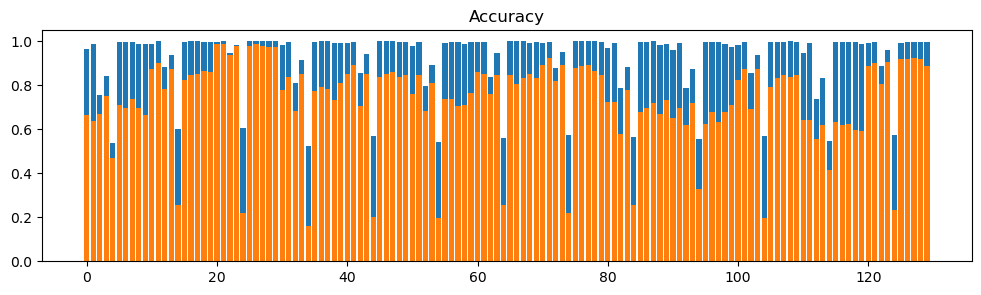

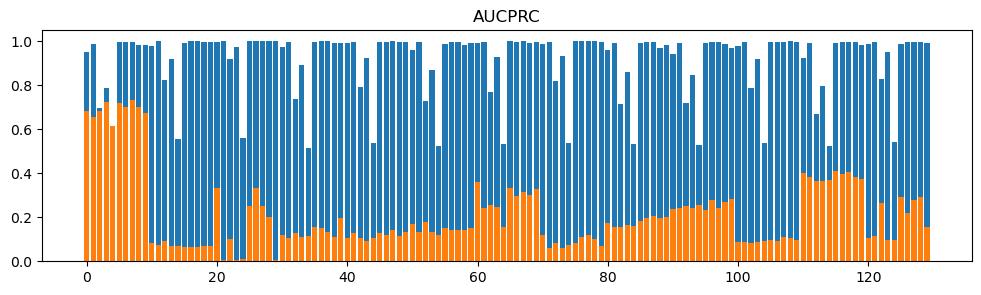

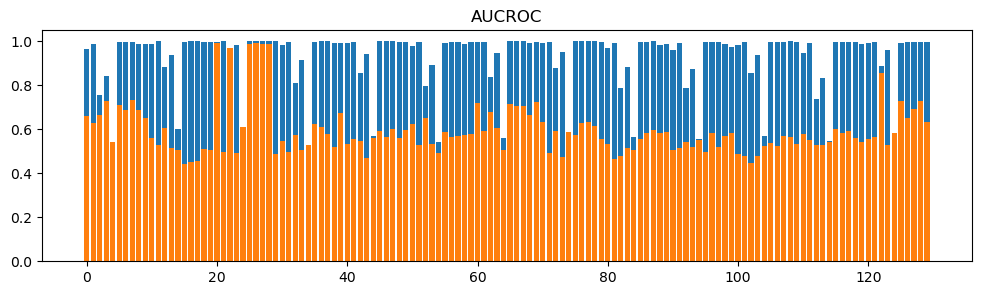

In [16]:
import matplotlib.pyplot as plt

start = 0
end = start + 130

plt.figure(figsize=(12,3))
plt.bar(range(len(train_accuracies1[start:end])), train_accuracies1[start:end])
plt.bar(range(len(train_accuracies1[start:end])), val_accuracies1[start:end])
plt.title("Accuracy")
plt.show()
plt.figure(figsize=(12,3))
plt.bar(range(len(train_accuracies2[start:end])), train_accuracies2[start:end])
plt.bar(range(len(train_accuracies2[start:end])), val_accuracies2[start:end])
plt.title("AUCPRC")
plt.show()
plt.figure(figsize=(12,3))
plt.bar(range(len(train_accuracies3[start:end])), train_accuracies3[start:end])
plt.bar(range(len(train_accuracies3[start:end])), val_accuracies3[start:end])
plt.title("AUCROC")
plt.show()